In [1]:
# Run the cell below if you want to have output of the cells on their side
# reload the page to get back to the default way.
# You can edit background colors below (change the hex #RGB values)
# Taken from:
# https://github.com/jupyter/notebook/issues/2897#issuecomment-442959381

In [4]:
%%html
<style>
#notebook-container {
    width: 100%;
    background-color: #111
}

.code_cell {
   flex-direction: row !important;
}

.code_cell .output_wrapper {
    width: 50%;
    background-color: #333
}

.code_cell .input {
    width: 50%;
    background-color: #222
}
</style>

In [5]:
"""To get the list of serial ports"""

import sys
import glob
import serial


def serial_ports():
    """ Lists serial port names

        :raises EnvironmentError:
            On unsupported or unknown platforms
        :returns:
            A list of the serial ports available on the system
    """
    if sys.platform.startswith('win'):
        ports = ['COM%s' % (i + 1) for i in range(256)]
    elif sys.platform.startswith('linux') or sys.platform.startswith('cygwin'):
        # this excludes your current terminal "/dev/tty"
        ports = glob.glob('/dev/tty[A-Za-z]*')
    elif sys.platform.startswith('darwin'):
        ports = glob.glob('/dev/tty.*')
    else:
        raise EnvironmentError('Unsupported platform')

    result = []
    for port in ports:
        try:
            s = serial.Serial(port)
            s.close()
            result.append(port)
        except (OSError, serial.SerialException):
            pass
    return result



print(serial_ports())

ModuleNotFoundError: No module named 'serial'

In [2]:
try:
    sc.serial.close()
except:
    pass

import logging
import time

import serial_connection

def flush():
    print('flushing...')
    for i in range(5):
        t1 = time.time()
        print(sc.readline())
        t2 = time.time()
        print("time [s]:", t2-t1)
    time.sleep(0.5)

In [3]:
# To autoreload imported libraries:    
%load_ext autoreload
%autoreload 2

logging.basicConfig(level=logging.DEBUG)

DAC1_port = 'COM23' # On the lab computer
DAC1_port = 'COM8'  # On my laptop
sc = serial_connection.serialConnection(port=DAC1_port, baud_rate=19200, string_terminator='\r')

INFO:root:Serial opened on port COM8 with baud rate 19200


In [4]:
logging.basicConfig(level=logging.INFO)
logging.getLogger().setLevel(logging.INFO)

flush()    

print('heeej')

a = sc.send_string('?VS', wait_for_answer=True)

flush()

print('-------')
print(a)
print(int(a.split(' ')[1]))

flushing...
bytearray(b'Setup done.\r\n')
time [s]: 0.0009975433349609375
bytearray(b'File: V01_voltageControl.1\r\n')
time [s]: 0.0

time [s]: 0.11636662483215332

time [s]: 0.1067650318145752

time [s]: 0.10854482650756836
heeej
flushing...
bytearray(b'That was VsensePin [mV] \r\n')
time [s]: 0.003961801528930664

time [s]: 0.10253238677978516

time [s]: 0.1090395450592041

time [s]: 0.1094205379486084

time [s]: 0.10855436325073242
-------
#VS 3005
3005


In [8]:
logging.getLogger().setLevel(logging.INFO)

a = sc.send_string('!PA 0', wait_for_answer=False)
flush()    

print('---------')

flushing...

time [s]: 0.10295224189758301

time [s]: 0.10784792900085449

time [s]: 0.10872054100036621

time [s]: 0.10906839370727539

time [s]: 0.10888457298278809
---------


# Run experiment

In [9]:
import numpy as np

measurements = []
mode = ['step', 'sine', 'heavy_side'][2]

dT = 0.0#5
N = 500

t_1 = 0.5
t_duration = 5
t_2 = t_1 + t_duration

t_start = time.time()

for i in range(N):
    if mode == 'step':
        if i//20 % 2:
            voltage = 100
        else:
            voltage = 0
    elif mode == 'sine':
        voltage = int(600 + 500*np.sin(2*3.1415*i/7))
    elif mode == 'heavy_side':
        t = time.time() - t_start
        if t > t_2:
            voltage = 0
        elif t > t_1:
            voltage = 1000
        else:
            voltage = 0
    else:
        print('mode undefined')
#     print(voltage)
        
    
#     VI = voltage
    a = sc.send_string('!VI ' + str(voltage), wait_for_answer=True)
    VI = int(a.split(' ')[1])
    
    a = sc.send_string('?VS', wait_for_answer=True)
    VS = int(a.split(' ')[1])
    t = time.time() - t_start

    measurements.append([t, VI, VS])
    
    time.sleep(dT)

print('Done')

Done


# Plot the measurements

<IPython.core.display.Javascript object>


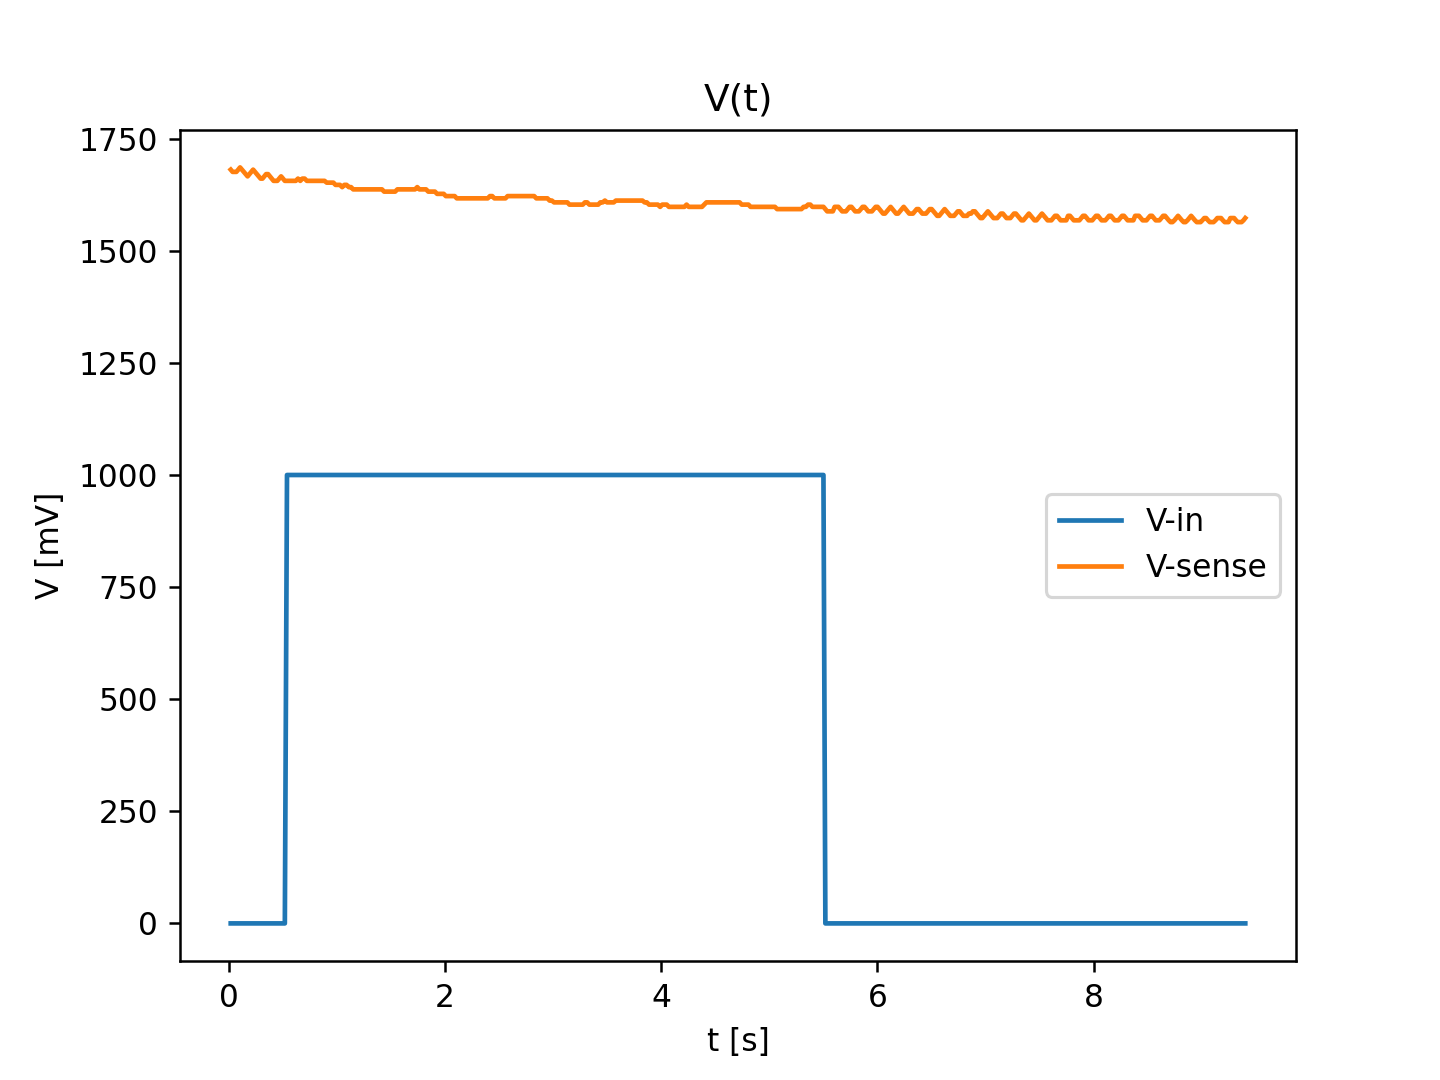

In [10]:
import matplotlib.pyplot as plt
%matplotlib notebook 
    
data = np.array(measurements)
fig = plt.figure()
fig.patch.set_facecolor('white')


plt.plot(data[:, 0], data[:, 1], label='V-in')
plt.plot(data[:, 0], data[:, 2], label='V-sense')
plt.title('V(t)')
plt.legend()
plt.xlabel('t [s]')
plt.ylabel('V [mV]')
plt.show()


In [100]:
file_counter = 0

In [103]:
# Save the data to text file
folder = 'measurements/'

file_counter += 1
file_name = folder + 'voltage_timeseries_' + str(file_counter) + '.txt'

comment = input('Enter the comment for the saved file:')
header_text = 't[s] Vin[mV] Vsense[mV]    comment: ' + comment
np.savetxt(file_name, data, header=header_text)
print('File saved. Name:', file_name)


Enter the comment for the saved file:first test. some results seen.
